In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
import copy


In [2]:
transform = transforms.ToTensor()

traindataset = datasets.FashionMNIST('.', download=True, train=True, transform=transform)
testdataset = datasets.FashionMNIST('.', download=True, train=False, transform=transform)

In [3]:
batch_size = 16
trainloader = torch.utils.data.DataLoader(traindataset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testdataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [19]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 28*28),
            nn.ReLU()
        )
  
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
net = AutoEncoder()
net = net.cuda()
net

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=784, bias=True)
    (3): ReLU()
  )
)

In [5]:
init_weights = copy.deepcopy(net.encoder[0].weight.data)

In [20]:
optimizer = optim.SGD(net.parameters(), lr=0.5, momentum=0.9)
criterion = nn.MSELoss()

In [21]:
epochs = 5
for epoch in range(epochs):
    runningloss = 0
  
    for images, labels in trainloader:
        images, labels = images.view(images.size()[0], -1).cuda(), labels.cuda()
        optimizer.zero_grad()
        output = net(images)
        loss = criterion(output, images.view(images.size()[0], -1))
        loss.backward()
        optimizer.step()
        runningloss += loss.item()/images.shape[0]
    print('Epoch: {}/{} \t Mean Square Error Loss: {}'.format(epoch+1, epochs, runningloss))

Epoch: 1/5 	 Mean Square Error Loss: 8.741306127049029
Epoch: 2/5 	 Mean Square Error Loss: 5.420741587877274
Epoch: 3/5 	 Mean Square Error Loss: 4.877352174546104
Epoch: 4/5 	 Mean Square Error Loss: 4.546721620950848
Epoch: 5/5 	 Mean Square Error Loss: 4.35326160461409


In [22]:
next(iter(testloader))[0].shape

torch.Size([16, 1, 28, 28])

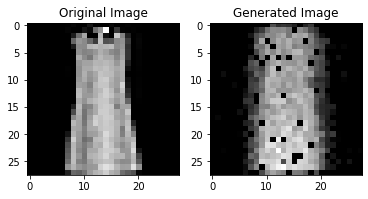

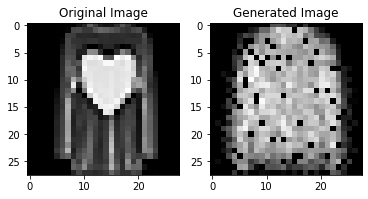

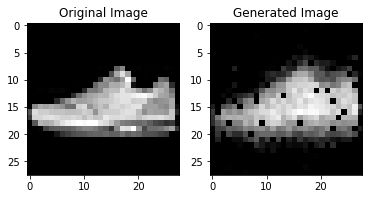

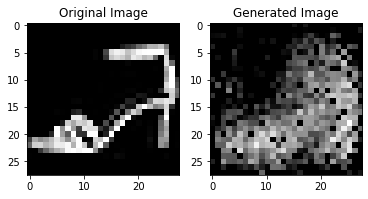

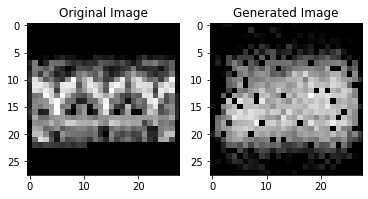

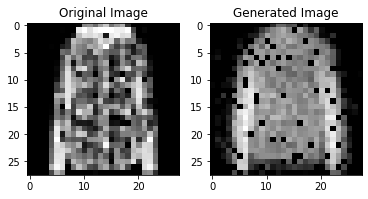

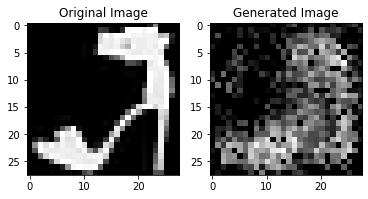

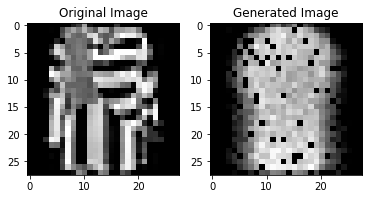

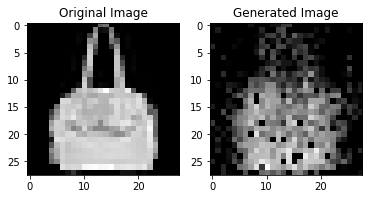

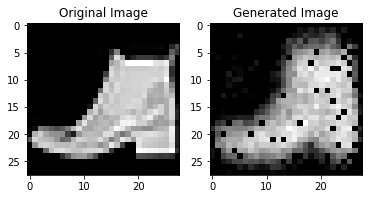

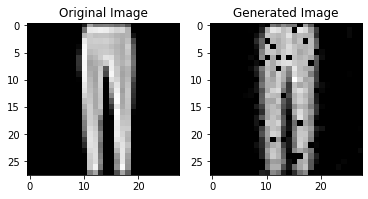

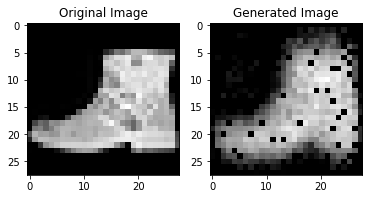

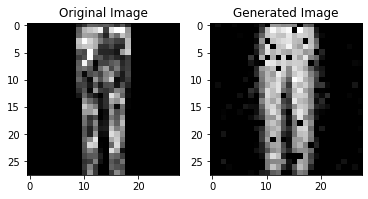

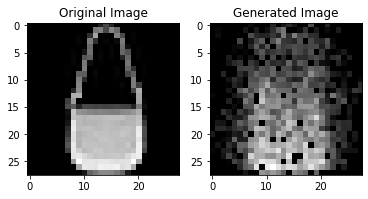

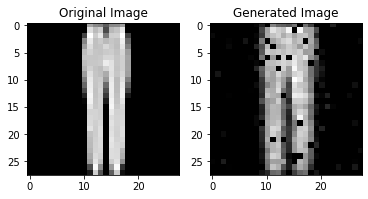

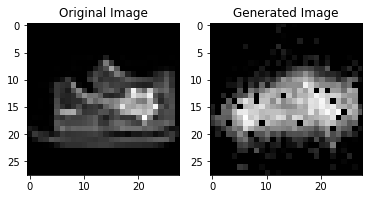

In [7]:
test_images, labels = next(iter(testloader))

test_images = images.view(images.size()[0], -1).cuda()
test_output, predicted = net(test_images)

  
inp = test_images.view(-1, 28, 28)
out = test_output.view(-1, 28, 28)

for i in range(len(inp)):
    fig = plt.figure()
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title('Original Image')
    imgplot = plt.imshow(inp[i].cpu(), cmap='gray')

    plot = fig.add_subplot(1, 2, 2)
    plot.set_title('Generated Image')
    imgplot = plt.imshow(out[i].cpu().detach(), cmap='gray')
    plt.show()

In [4]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 28*28),
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Linear(100, 10),
            nn.LogSoftmax(dim=1)
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        predicted = self.classifier(encoded)
        return decoded, predicted
net = AutoEncoder()
net = net.cuda()
net

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=784, bias=True)
    (3): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=100, out_features=10, bias=True)
    (1): LogSoftmax()
  )
)

In [11]:
new_classifier = nn.Sequential(*list(net.children())[:-1])
net = new_classifier
net.add_module('classifier', nn.Sequential(nn.Linear(100, 10),nn.LogSoftmax(dim=1)))
net.cuda()
net

Sequential(
  (0): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=100, out_features=10, bias=True)
    (1): LogSoftmax()
  )
)

In [12]:
cll_weights = copy.deepcopy(net[0][0].weight.data)
init_classifier_weights = copy.deepcopy(net.classifier[0].weight.data)

In [5]:
criterion1 = nn.MSELoss()
criterion2 = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [6]:
epochs = 20
for epoch in range(epochs):
    runningloss = 0
  
    for images, labels in testloader:
        images, labels = images.view(images.size()[0], -1).cuda(), labels.cuda()
        decoded, predicted = net(images)
        #print(images.shape) #16x784
        #print(labels.shape) #16
        #print(output.shape) #16x10
        optimizer.zero_grad()
        loss1 = criterion1(decoded,images)
        loss2 = criterion2(predicted, labels)
        loss = loss1+loss2
        loss.backward()
        optimizer.step()
        runningloss += loss.item()/images.shape[0]
  

    net.eval()
    total_correct = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.view(images.size()[0], -1).cuda(), labels.cuda()
            decoded, output_acc = net(images)
            _, pred = torch.max(output_acc, 1)
            total_correct += torch.sum(pred==labels).item()
        accuracy = total_correct / len(testloader.dataset)
    print('Epoch: {}/{} \t Training Loss: {}, Test Accuracy: {}'.format(epoch, epochs, runningloss, accuracy))

Epoch: 0/20 	 Training Loss: 40.75040466338396, Test Accuracy: 0.7669
Epoch: 1/20 	 Training Loss: 25.831737498752773, Test Accuracy: 0.7719
Epoch: 2/20 	 Training Loss: 23.2052153442055, Test Accuracy: 0.7707
Epoch: 3/20 	 Training Loss: 21.39738867804408, Test Accuracy: 0.7915
Epoch: 4/20 	 Training Loss: 19.957742498256266, Test Accuracy: 0.8147
Epoch: 5/20 	 Training Loss: 18.648721714504063, Test Accuracy: 0.8298
Epoch: 6/20 	 Training Loss: 17.725140907801688, Test Accuracy: 0.8438
Epoch: 7/20 	 Training Loss: 17.051200104877353, Test Accuracy: 0.8537
Epoch: 8/20 	 Training Loss: 16.350434099324048, Test Accuracy: 0.8711
Epoch: 9/20 	 Training Loss: 15.61167972208932, Test Accuracy: 0.8761
Epoch: 10/20 	 Training Loss: 15.104479334317148, Test Accuracy: 0.8736
Epoch: 11/20 	 Training Loss: 14.285123458132148, Test Accuracy: 0.8795
Epoch: 12/20 	 Training Loss: 14.055161107797176, Test Accuracy: 0.8823
Epoch: 13/20 	 Training Loss: 13.604764117160812, Test Accuracy: 0.8907
Epoch: 

In [26]:
epochs = 5
for epoch in range(epochs):
    runningloss = 0
  
    for images, labels in testloader:
        images, labels = images.view(images.size()[0], -1).cuda(), labels.cuda()
        output = net(images)
        #print(images.shape) #16x784
        #print(labels.shape) #16
        #print(output.shape) #16x10
        optimizer.zero_grad()
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        runningloss += loss.item()/images.shape[0]
  

    net.eval()
    total_correct = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.view(images.size()[0], -1).cuda(), labels.cuda()
            output_acc = net(images)
            _, pred = torch.max(output_acc, 1)
            total_correct += torch.sum(pred==labels).item()
        accuracy = total_correct / len(testloader.dataset)
    print('Epoch: {}/{} \t Training Loss: {}, Test Accuracy: {}'.format(epoch, epochs, runningloss, accuracy))



Epoch: 0/5 	 Training Loss: 35.89347675256431, Test Accuracy: 0.776
Epoch: 1/5 	 Training Loss: 22.122648192569613, Test Accuracy: 0.7911
Epoch: 2/5 	 Training Loss: 19.59754120418802, Test Accuracy: 0.8147
Epoch: 3/5 	 Training Loss: 18.04532377142459, Test Accuracy: 0.8317
Epoch: 4/5 	 Training Loss: 16.867803036700934, Test Accuracy: 0.8366
